In [ ]:
pip install mesa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 4.1 MB/s eta 0:00:00


In [ ]:
pip install -U mesa[rec]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.4/263.4 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.6 MB/s eta 0:00:00


Step 0:


<ipython-input-11-0c8a005264bd>:56: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


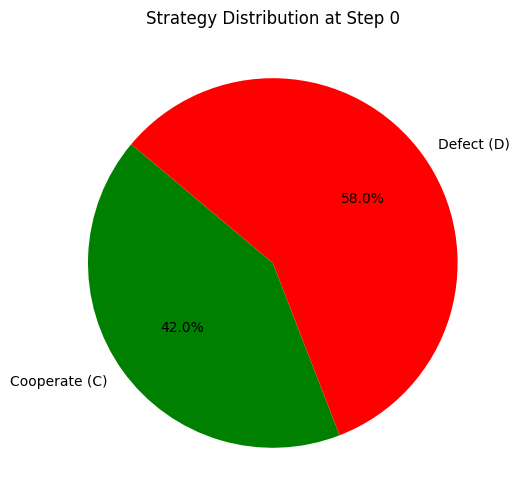

Step 10:


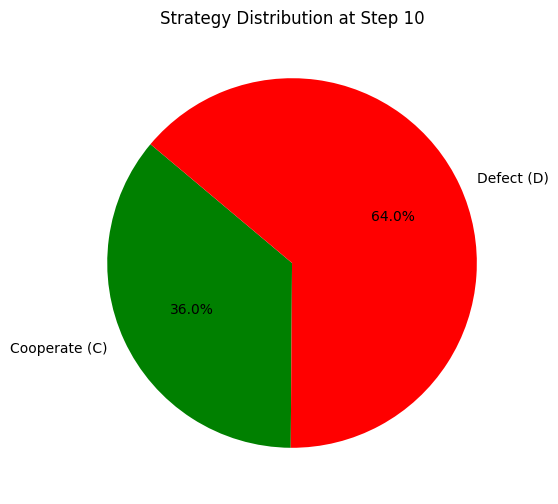

Step 20:


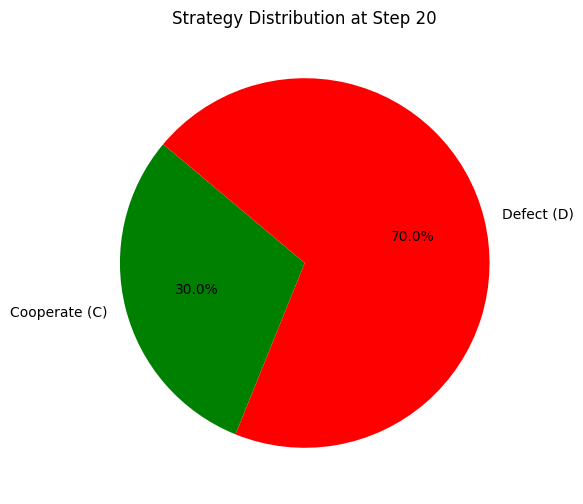

Step 30:


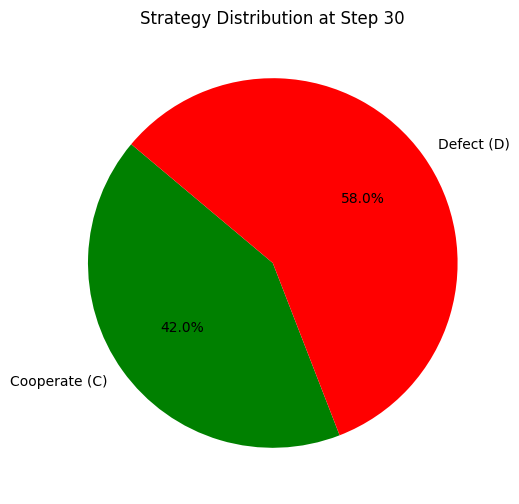

Step 40:


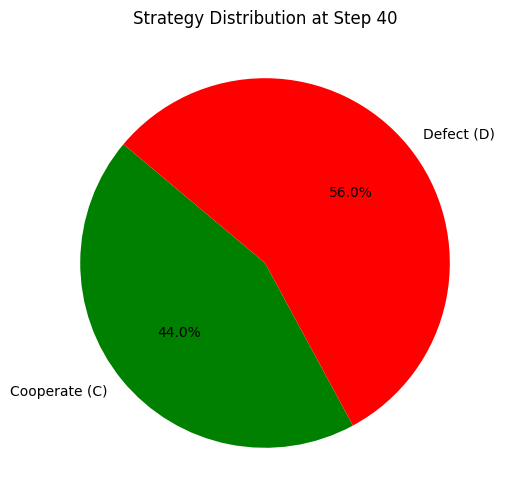

Step 50:


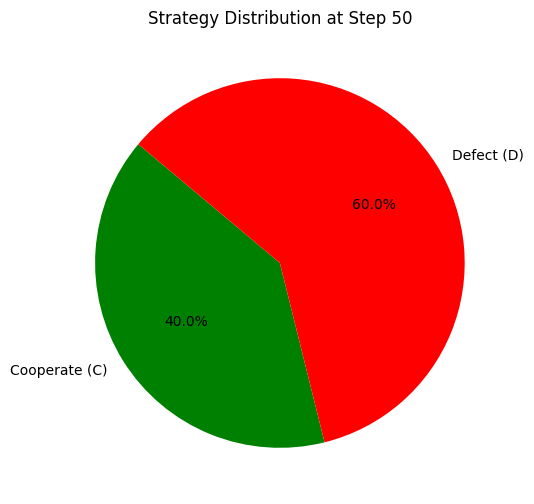

Step 60:


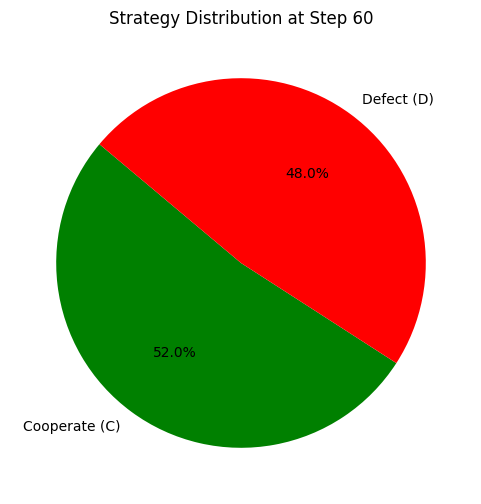

Step 70:


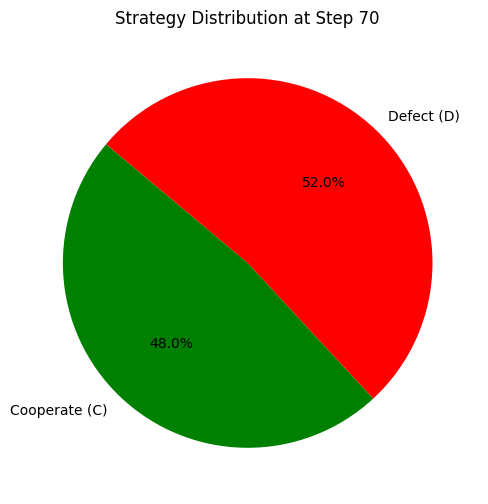

Step 80:


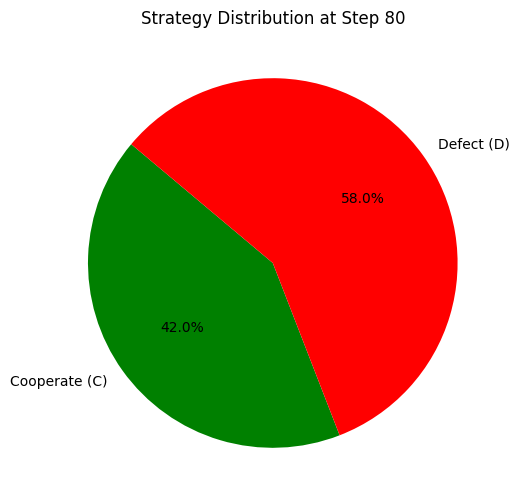

Step 90:


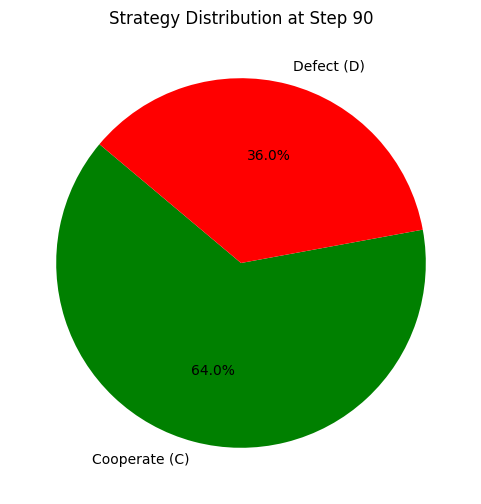

Step 100:


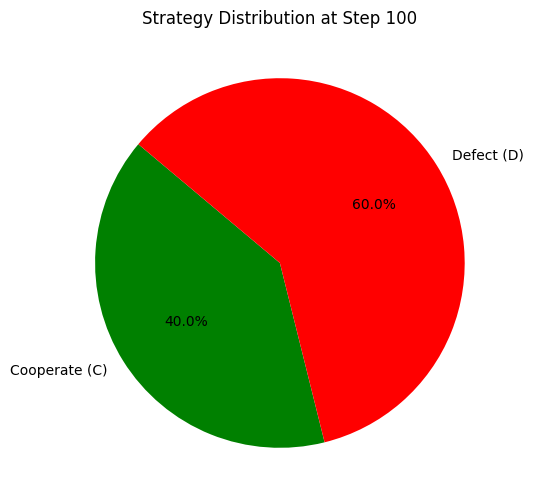

Step 110:


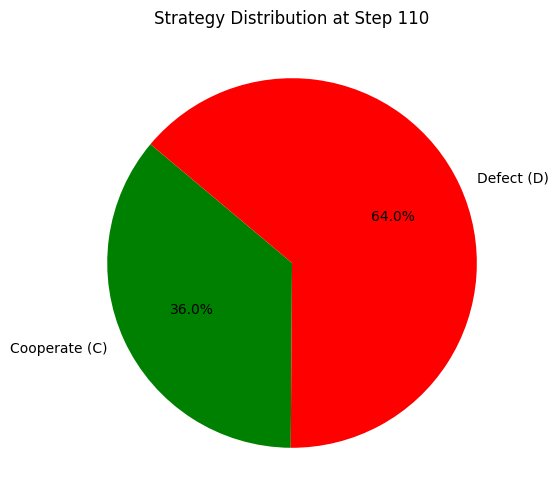

Step 120:


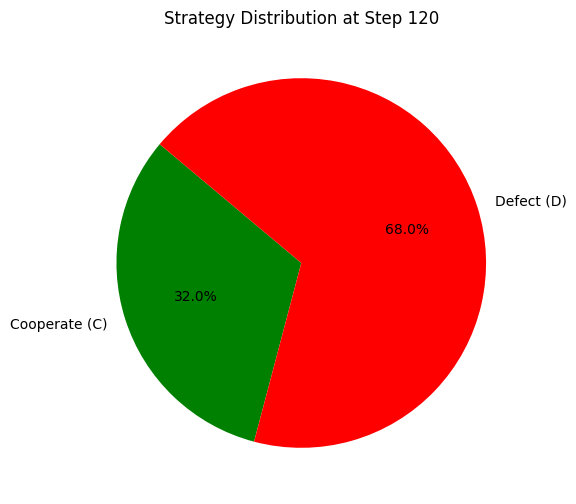

Step 130:


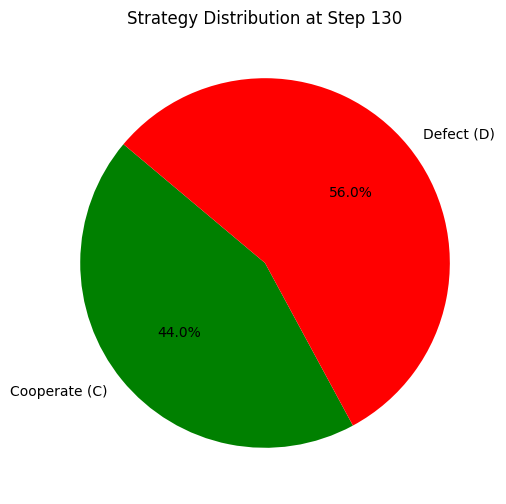

Step 140:


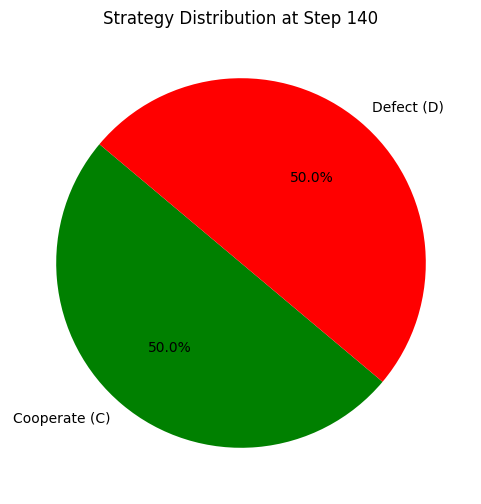

Step 150:


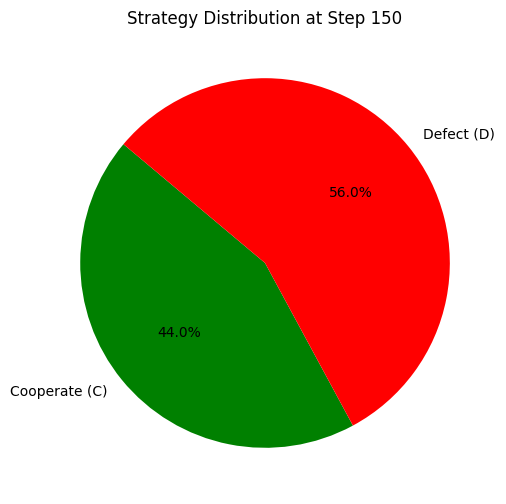

Step 160:


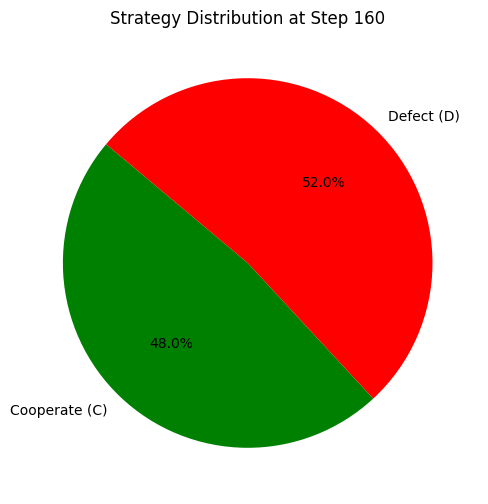

Step 170:


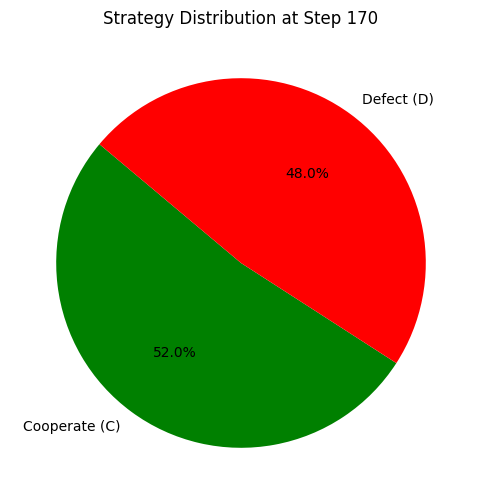

Step 180:


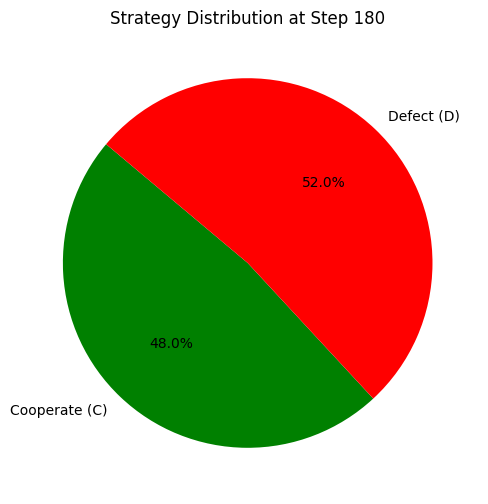

Step 190:


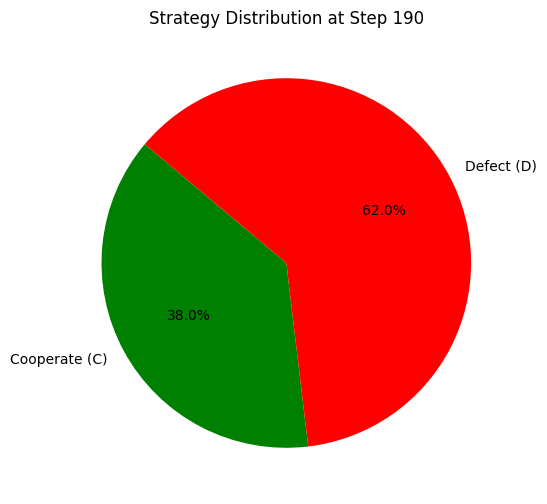

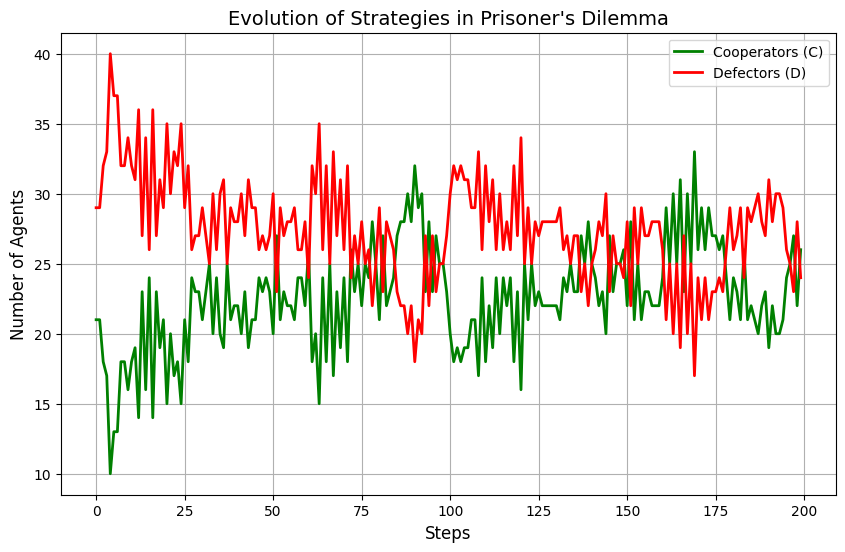

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
import numpy as np

# Define the Prisoner agent
class Prisoner(Agent):
    def __init__(self, model, strategy="C"):
        super().__init__(model)
        self.strategy = strategy  # "C" for Cooperate, "D" for Defect
        self.payoff = 0

    def play_game(self, opponent):
        # Payoff matrix logic
        if self.strategy == "C" and opponent.strategy == "C":
            self.payoff += 3
            opponent.payoff += 3
        elif self.strategy == "C" and opponent.strategy == "D":
            self.payoff += 0
            opponent.payoff += 5
        elif self.strategy == "D" and opponent.strategy == "C":
            self.payoff += 5
            opponent.payoff += 0
        else:  # Both defect
            self.payoff += 1
            opponent.payoff += 1

    def adapt_strategy(self, avg_payoff):
        # Adapt strategy based on relative payoff and exploration
        exploration_rate = 0.1  # 10% chance of random exploration
        if self.random.random() < exploration_rate:
            self.strategy = self.random.choice(["C", "D"])  # Randomly explore
            return

        # Compare own payoff to average payoff
        if self.payoff > avg_payoff:
            # Stick with the current strategy if it performs well
            return
        else:
            # Probabilistically switch to the other strategy
            switch_probability = 1 / (1 + np.exp(self.payoff - avg_payoff))
            if self.random.random() < switch_probability:
                self.strategy = "C" if self.strategy == "D" else "D"

    def step(self):
        # Randomly select an opponent
        opponent = self.random.choice(self.model.schedule.agents)
        self.play_game(opponent)


# Define the Game model
class GameModel(Model):
    def __init__(self, num_agents):
        super().__init__()
        self.schedule = RandomActivation(self)
        self.num_agents = num_agents

        # Create agents
        for _ in range(self.num_agents):
            agent = Prisoner(self, strategy=self.random.choice(["C", "D"]))
            self.schedule.add(agent)

        # Data collector
        self.datacollector = DataCollector(
            model_reporters={
                "Cooperators": lambda m: sum(1 for a in m.schedule.agents if a.strategy == "C"),
                "Defectors": lambda m: sum(1 for a in m.schedule.agents if a.strategy == "D"),
            }
        )

    def step(self):
        # Compute average payoff for the population
        total_payoff = sum(agent.payoff for agent in self.schedule.agents)
        avg_payoff = total_payoff / self.num_agents if self.num_agents > 0 else 0

        # Activate all agents
        for agent in self.schedule.agents:
            agent.step()

        # Allow agents to adapt their strategies
        for agent in self.schedule.agents:
            agent.adapt_strategy(avg_payoff)

        # Collect data
        self.datacollector.collect(self)


# Visualization functions
def plot_results(model):
    # Collect data
    data = model.datacollector.get_model_vars_dataframe()

    # Plot strategy proportions over time
    plt.figure(figsize=(10, 6))
    plt.plot(data["Cooperators"], label="Cooperators (C)", color="green", linewidth=2)
    plt.plot(data["Defectors"], label="Defectors (D)", color="red", linewidth=2)
    plt.title("Evolution of Strategies in Prisoner's Dilemma", fontsize=14)
    plt.xlabel("Steps", fontsize=12)
    plt.ylabel("Number of Agents", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


def visualize_strategy_distribution(model, step):
    strategies = [agent.strategy for agent in model.schedule.agents]
    counts = {"C": strategies.count("C"), "D": strategies.count("D")}

    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        counts.values(),
        labels=["Cooperate (C)", "Defect (D)"],
        autopct="%1.1f%%",
        colors=["green", "red"],
        startangle=140,
    )
    plt.title(f"Strategy Distribution at Step {step}")
    plt.show()


# Run the simulation
if __name__ == "__main__":
    model = GameModel(num_agents=50)
    steps = 200

    for step in range(steps):
        model.step()
        if step % 10 == 0:  # Visualize every 10 steps
            print(f"Step {step}:")
            visualize_strategy_distribution(model, step)

    # Plot overall results
    plot_results(model)
